<a href="https://colab.research.google.com/github/AlexandreMorinvil/MNIST-digit-recognizer/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This solution is inpired by the following resources :
# - https://www.kaggle.com/code/amirhoseinsedaghati/digit-classification-using-cnn-0-9974-score
# - https://www.kaggle.com/code/skv1436/mnist-cnn-accuracy-0-99

## Initializing the environment

### Imports

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

### Importing the data

In [3]:
!pip install kaggle

In [4]:
# A Kaggle API key is store in the Google Drive folder called 'kaggle', located
# at the root of the Drive.

# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

!rm -r ~/.kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c digit-recognizer

! mkdir data
! unzip digit-recognizer.zip -d data

# Unmount your Google Drive
drive.flush_and_unmount()

Mounted at /content/drive
rm: cannot remove '/root/.kaggle': No such file or directory
 52% 8.00M/15.3M [00:00<00:00, 80.8MB/s]
100% 15.3M/15.3M [00:00<00:00, 105MB/s] 
Archive:  digit-recognizer.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [5]:
! ls kaggle_data

ls: cannot access 'kaggle_data': No such file or directory


## EDA

In [6]:
train_df = pd.read_csv('data/train.csv')
target_df = pd.read_csv('data/test.csv')

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [8]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [9]:
train_df.shape

(42000, 785)

In [10]:
train_image, train_label = train_df.iloc[:, 1:].values, train_df['label'].values

In [11]:
train_image = train_image.reshape((-1, 28, 28))
target_image = target_df.values.reshape((-1, 28, 28))

In [12]:
print(f'Shape of the training images: {train_image.shape}\nShape of the target images: {target_image.shape}')

Shape of the training images: (42000, 28, 28)
Shape of the target images: (28000, 28, 28)


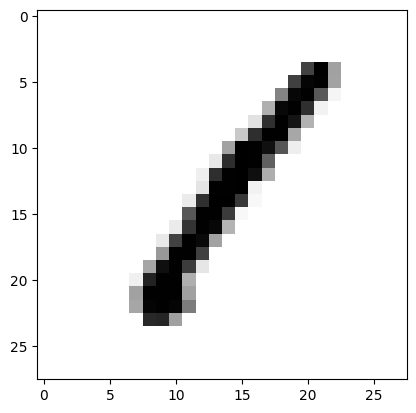

In [13]:
plt.imshow(train_image[0].reshape(28, 28), cmap=plt.cm.gray_r)

In [14]:
def display_images(images, labels=None, start=0, images_count=5):

    rows_count = math.ceil(images_count / 10)
    columns_count = min(10, images_count)
    counter = 0

    fig = plt.figure(figsize=(10, rows_count + 1))
    for i in range(images_count):
        index = start + i
        plt.subplot(rows_count, columns_count, i + 1)
        plt.imshow(images[index], cmap=plt.cm.gray_r);
        plt.axis('off');
        plt.title(f'{labels[index]}');

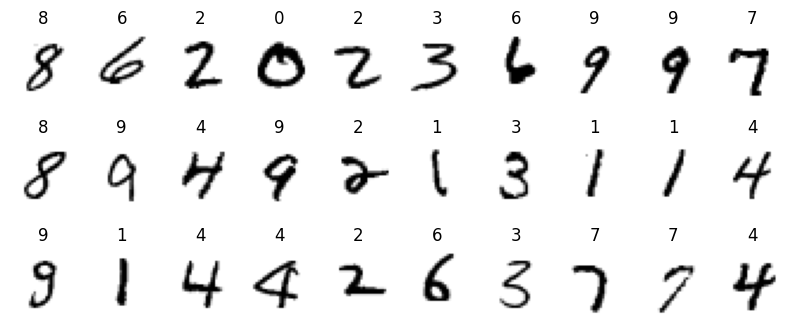

In [15]:
display_images(train_image, train_label, start=20, images_count=30)

[Text(0.5, 1.0, 'Number of images in each class')]

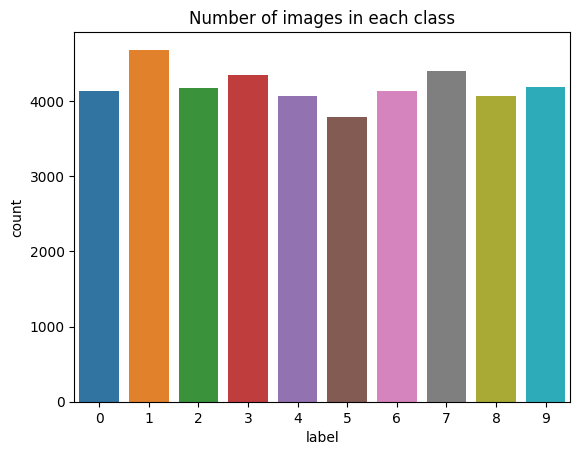

In [16]:
sns.countplot(x='label', data=train_df).set(title='Number of images in each class')

## Preprocessing

### Scaling
Scaling the pixels will make all the pixels have the same magnitude, which will help the neural network to associate proper weights to every relevant pixel.

In [35]:
preprocessed_train_image = train_image.reshape(-1, 28, 28, 1) / 255.0

We can see that the images displayed still correspond to the initial images.

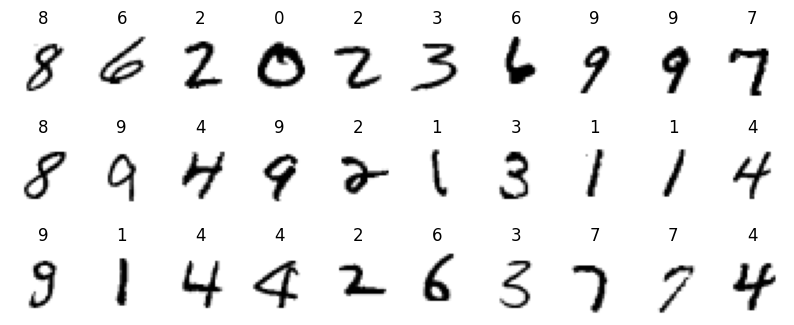

In [36]:
display_images(preprocessed_train_image, train_label, start=20, images_count=30)

## Data Modeling

In [50]:
import tensorflow as tf
from tensorflow.keras.models import save_model, load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.model_selection import train_test_split

In [51]:
print("TensorFlow version:", tf.__version__)
print("Is Tensorflow built with CUDA:", tf.test.is_built_with_cuda())

TensorFlow version: 2.12.0
Is Tensorflow built with CUDA: True


In [57]:
def create_model():
    model = Sequential()

    # Convolution section
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2,2), strides=2))

    # Dense layer section
    model.add(Flatten())

    # Fully Connected Layer (with Relu activation)
    model.add(Dense(128, activation="relu", name="Fully_connected_1"))
    model.add(Dense(10, activation="softmax", name="Fully_connected_2"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

model = create_model()

In [58]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 3136)              0         
                                                                 
 Fully_connected_1 (Dense)   (None, 128)             

Observations after experimenting with different Neural Network architectures :

*   The last layer must have a "Softmax" activation function (otherwise the
neural netwok will simply not give the desired predictions)
*   Simply



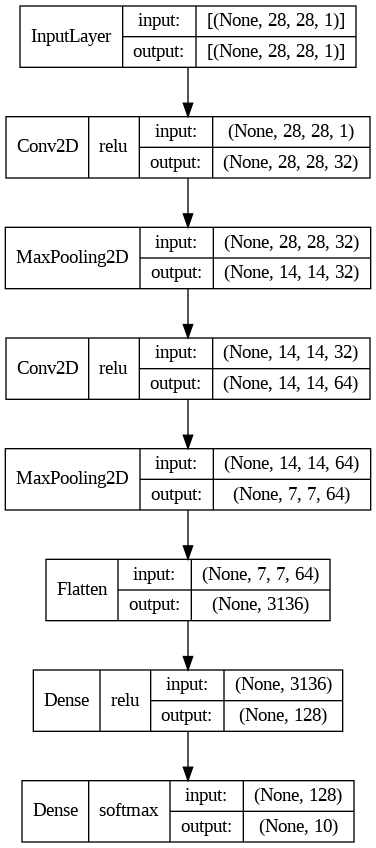

In [59]:
plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=False)

Training the model and validating its accuracy

In [60]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(x=preprocessed_train_image,
                    y=train_label,
                    epochs=30,
                    verbose=1,
                    callbacks=[callback],
                    validation_split=0.2)

Epoch 1/30
1050/1050 [==============================] - 68s 63ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.0709 - val_sparse_categorical_accuracy: 0.9769
Epoch 2/30
1050/1050 [==============================] - 67s 64ms/step - loss: 0.0499 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.0435 - val_sparse_categorical_accuracy: 0.9865
Epoch 3/30
1050/1050 [==============================] - 69s 66ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.0452 - val_sparse_categorical_accuracy: 0.9856
Epoch 4/30
1050/1050 [==============================] - 66s 63ms/step - loss: 0.0249 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.0457 - val_sparse_categorical_accuracy: 0.9871
Epoch 5/30
1050/1050 [==============================] - 64s 61ms/step - loss: 0.0190 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.0486 - val_sparse_categorical_accuracy: 0.9869
Epoch 6/30
1050/1050 [==============================] - 66s 63ms/step - loss: 0.

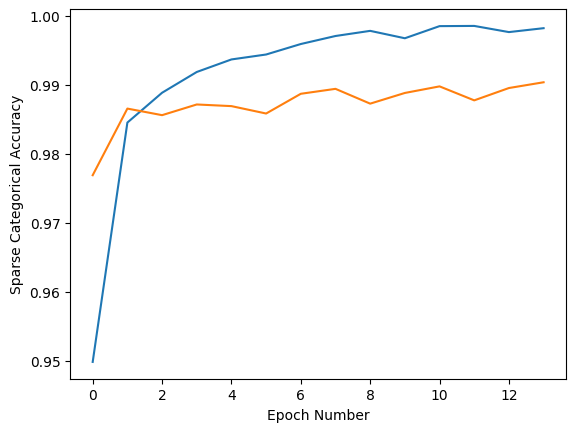

In [61]:
plt.xlabel('Epoch Number')
plt.ylabel("Sparse Categorical Accuracy")
plt.plot(history.history['sparse_categorical_accuracy'], label='Training')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation')

## Predictions

In [62]:
# Training the model on all the data
model = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(x=preprocessed_train_image,
                    y=train_label,
                    epochs=15,
                    verbose=1)

Epoch 1/15
1313/1313 [==============================] - 73s 55ms/step - loss: 0.1523 - sparse_categorical_accuracy: 0.9531
Epoch 2/15
1313/1313 [==============================] - 71s 54ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9853
Epoch 3/15
1313/1313 [==============================] - 72s 55ms/step - loss: 0.0318 - sparse_categorical_accuracy: 0.9897
Epoch 4/15
1313/1313 [==============================] - 72s 55ms/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9919
Epoch 5/15
1313/1313 [==============================] - 72s 55ms/step - loss: 0.0174 - sparse_categorical_accuracy: 0.9945
Epoch 6/15
1313/1313 [==============================] - 72s 55ms/step - loss: 0.0124 - sparse_categorical_accuracy: 0.9959
Epoch 7/15
1313/1313 [==============================] - 72s 55ms/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9967
Epoch 8/15
1313/1313 [==============================] - 78s 59ms/step - loss: 0.0094 - sparse_categorical_accuracy: 0.9968
Epoch 9/15
1313/

In [63]:
predictions = np.argmax(model.predict(target_image), axis=1)

875/875 [==============================] - 61s 15ms/step


<Axes: >

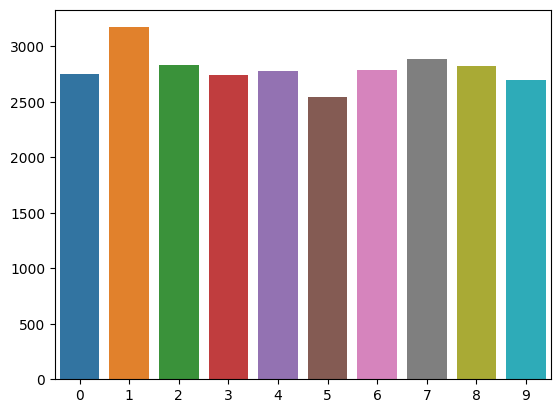

In [64]:
label, count = np.unique(predictions, return_counts=True)
sns.barplot(x=label, y=count)

In [65]:
submission_df = pd.DataFrame(data={
   'ImageId': list(range(1, len(predictions) + 1)),
   'Label': predictions,
})
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [66]:
submission_df.to_csv('submission.csv', index=False)

In [67]:
# submit the file to kaggle
! kaggle competitions submit digit-recognizer -f submission.csv -m "Submission after utilizing a neural network involving Convolutional Layers and Maxpooling layers"

100% 208k/208k [00:01<00:00, 148kB/s]  
Successfully submitted to Digit Recognizer